In [6]:
import pandas as pd
from io import StringIO
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

path_csv = '.'

# Read the CSV files into pandas dataframes
formal_model = pd.read_csv(f"{path_csv}/formal_model.csv")

In [7]:
formal_model

,Formal Model,f1,f2,f3,f4,f5
0,1,2.8,-1.8,-2.800000,1.300000,0.4
1,2,2.9,-1.9,-2.900000,1.400000,0.5
2,3,3.0,-2.0,-3.000000,1.500000,0.6
3,4,3.1,-2.1,-3.100000,1.600000,0.7
4,5,3.2,-2.2,-3.200000,1.700000,0.8
5,6,-1.6,-2.5,1.500000,0.200000,0.6
6,7,-1.3,-2.7,1.300000,0.400000,0.8
7,8,-1.0,-3.0,1.500000,0.600000,1.0
8,9,-0.7,-3.2,1.700000,0.800000,1.2
9,10,-0.5,-3.5,1.900000,1.000000,1.4


In [8]:
# The table data you provided
data = """Formal Model,f1,f2,f3,f4,f5
1,2.8,-1.8,-2.8,1.3,0.4
2,2.9,-1.9,-2.9,1.4,0.5
3,3,-2,-3,1.5,0.6
4,3.1,-2.1,-3.1,1.6,0.7
5,3.2,-2.2,-3.2,1.7,0.8
6,-1.6,-2.5,1.5,0.2,0.6
7,-1.3,-2.7,1.3,0.4,0.8
8,-1,-3,1.5,0.6,1
9,-0.7,-3.2,1.7,0.8,1.2
10,-0.5,-3.5,1.9,1,1.4
11,1.2,-1.2,0.7,-0.3,-2.8
12,1.1,-1.1,0.8,-0.4,-2.9
13,1,-1,0.8444444444,-0.4444444444,-3
14,0.9,-0.9,0.85,-0.45,-3.1
15,0.8,-0.8,0.9,-0.5,-3.2"""

# Use StringIO to simulate a file object
csv_data = StringIO(data)

# Read the data into a pandas DataFrame named 'formal_model'
# formal_model = pd.read_csv(csv_data)

# Drop the 'Formal Model' column as it's an identifier and not part of the features
X = formal_model.drop('Formal Model', axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply MDS to reduce the dimensions to 2
mds = MDS(n_components=2, normalized_stress='auto')
X_mds = mds.fit_transform(X_scaled)

# Convert the reduced data back to a pandas DataFrame
reduced_formal_model = pd.DataFrame(X_mds, columns=["x1", "x2"])

print(reduced_formal_model)


          x1        x2
0   0.598984  1.891941
1   0.765661  1.976329
2   0.936522  2.057980
3   1.104990  2.143114
4   1.291743  2.210994
5   0.534812 -1.934067
6   0.856379 -1.700157
7   1.282960 -1.605996
8   1.641448 -1.502283
9   2.090950 -1.464153
10 -1.944149 -0.278080
11 -2.100596 -0.383819
12 -2.230630 -0.439718
13 -2.342268 -0.475320
14 -2.486805 -0.496766


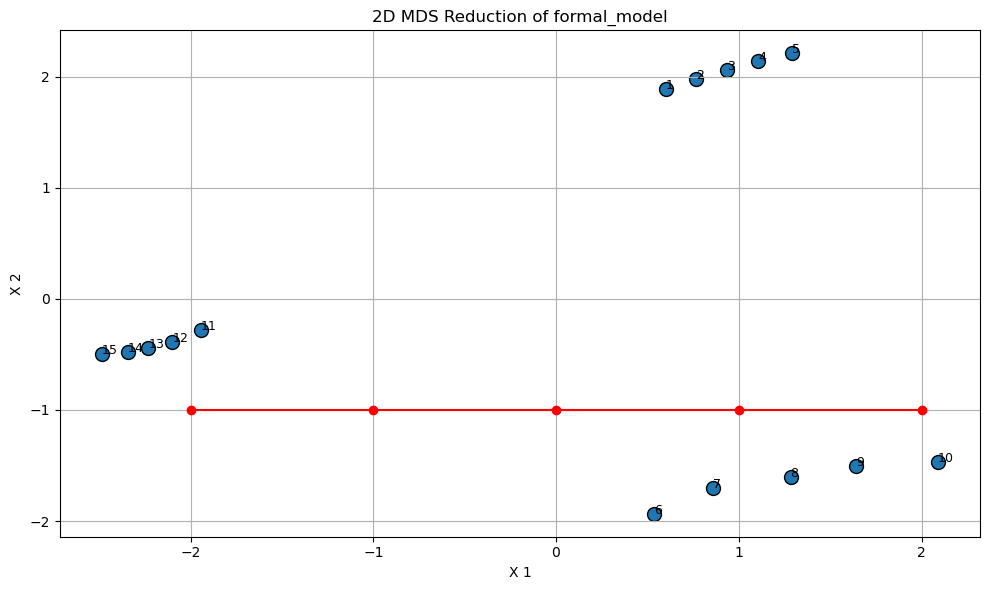

In [9]:
import matplotlib.pyplot as plt

# Scatter plot for the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(reduced_formal_model['x1'], reduced_formal_model['x2'], s=100, edgecolor='k')
for i, txt in enumerate(formal_model['Formal Model']):
    plt.annotate(txt, (reduced_formal_model['x1'].iloc[i], reduced_formal_model['x2'].iloc[i]), fontsize=9)

# Draw the separating line
# You might need to adjust these values based on your visualization
line_x1 = [-2, -1, 0, 1, 2]  # Example x-values for 5 points
line_x2 = [-1, -1, -1, -1, -1]  # Corresponding y-values, adjust to separate the classes
plt.plot(line_x1, line_x2, 'ro-')

plt.xlabel("X 1")
plt.ylabel("X 2")
plt.title("2D MDS Reduction of formal_model")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def get_intermediate_points(start, end, num_points):
    """
    Get intermediate points between start and end.

    Parameters:
    - start (tuple): The start point as (x, y)
    - end (tuple): The end point as (x, y)
    - num_points (int): Number of intermediate points

    Returns:
    - list of tuples: List containing the intermediate points
    """

    # Calculate fractions based on the number of intermediate points
    fractions = [(i+1)/(num_points+1) for i in range(num_points)]

    # Calculate intermediate points
    points = [(start[0] + (end[0] - start[0]) * fraction, start[1] + (end[1] - start[1]) * fraction) for fraction in fractions]

    return points, fractions

# Example usage:
start = (2, -4)
end = (-4, 1)
num_points = 5
print(get_intermediate_points(start, end, num_points)[1])


[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]
